In [1]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
import numpy as np

F_REF = 10.0        # Hz
CENTS_PER_BIN = 20
N_BINS = 300        # bins 0..299 (0 = unvoiced)

def hz_to_bin(f0_hz: np.ndarray):
    """
    f0_hz: (T,) float array, Hz, unvoiced = 0
    returns: (T,) int array, bins
    """
    bins = np.zeros_like(f0_hz, dtype=np.int64)
    voiced = f0_hz > 0

    cents = 1200 * np.log2(f0_hz[voiced] / F_REF)
    bins_voiced = np.floor(cents / CENTS_PER_BIN).astype(np.int64)

    bins_voiced = np.clip(bins_voiced, 1, N_BINS - 1)
    bins[voiced] = bins_voiced
    return bins


In [2]:
import os
import torch
from torch.utils.data import Dataset

class RRCGDDataset(Dataset):
    def __init__(self, base_dir, split):
        """
        base_dir/.../dataset
        split: train | test
        """
        self.split_dir = os.path.join(base_dir, split)
        self.rrcgd_dir = os.path.join(self.split_dir, "rrcgd")

        self.files = sorted([
            f.replace("_rrcgd.npy", "")
            for f in os.listdir(self.rrcgd_dir)
            if f.endswith("_rrcgd.npy")
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        key = self.files[idx]

        # X
        rrcgd = np.load(
            os.path.join(self.rrcgd_dir, key + "_rrcgd.npy")
        ).astype(np.float32)          # (T, 256)

        # Y (Hz → bins)
        pitch_hz = np.loadtxt(
            os.path.join(self.split_dir, key + ".pv"),
            usecols=0
        )[:len(rrcgd)]

        pitch_bin = hz_to_bin(pitch_hz)  # (T,)

        return {
            "x": torch.from_numpy(rrcgd),        # (T, 256)
            "y": torch.from_numpy(pitch_bin),    # (T,)
            "len": len(rrcgd)
        }


In [3]:
BASE_DIR = "/home/batch_2024/ee24s004/KT/RMVPE-RRCGD-spot-computation/dataset"

In [4]:
ds = RRCGDDataset(BASE_DIR, "train")
s = ds[0]

print(s["x"].shape)   # (T, 256)
print(s["y"].shape)   # (T,)
print("bins:", s["y"].min().item(), s["y"].max().item())

torch.Size([438, 256])
torch.Size([438])
bins: 0 155


# Training with a small model

In [24]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset

class RRCGDDataset(Dataset):
    def __init__(self, rrcgd_dir, label_dir):
        self.files = sorted([
            f for f in os.listdir(rrcgd_dir)
            if f.endswith("_rrcgd.npy")
        ])
        self.rrcgd_dir = rrcgd_dir
        self.label_dir = label_dir

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        rrcgd_path = os.path.join(self.rrcgd_dir, self.files[idx])
        label_path = os.path.join(
            self.label_dir,
            self.files[idx].replace("_rrcgd.npy", ".npy")
        )

        X = np.load(rrcgd_path)              # (T, 256)
        y_hz = np.load(label_path)        # (T,)

        y = hz_to_bin(y_hz)                  # (T,)
        return torch.from_numpy(X), torch.from_numpy(y)

In [25]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    Xs, Ys = zip(*batch)

    lengths = torch.tensor([x.shape[0] for x in Xs])

    Xs = pad_sequence(Xs, batch_first=True)  # (B, T, 256)
    Ys = pad_sequence(Ys, batch_first=True)  # (B, T)

    mask = (Ys != 0).float()                 # voiced mask

    return Xs, Ys, mask, lengths

In [28]:
import torch

def compute_metrics(logits, targets, mask, tol=1):
    """
    tol: pitch tolerance in bins (±tol for RPA)
    """
    with torch.no_grad():
        preds = torch.argmax(logits, dim=-1)  # (B,T)

        voiced_gt = targets > 0
        voiced_pred = preds > 0

        # VRR: voiced recall
        vrr = (voiced_pred & voiced_gt).sum() / (voiced_gt.sum() + 1e-8)

        # RPA: correct pitch within tolerance, only on voiced frames
        pitch_diff = torch.abs(preds - targets)
        rpa = ((pitch_diff <= tol) & voiced_gt).sum() / (voiced_gt.sum() + 1e-8)

        # OA: overall accuracy (voiced + unvoiced)
        oa = (preds == targets).sum() / targets.numel()

    return {
        "VRR": vrr.item(),
        "RPA": rpa.item(),
        "OA": oa.item()
    }

In [ ]:
def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    uv_weight=0.2
    for X, Y, mask, _ in loader:
        X, Y, mask = X.to(device), Y.to(device), mask.to(device)

        optimizer.zero_grad()
        logits = model(X)
        loss = masked_ce_loss(logits, Y, mask,uv_weight)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

In [30]:
def validate(model, loader, device):
    model.eval()
    agg = {"VRR":0, "RPA":0, "OA":0}
    n = 0

    with torch.no_grad():
        for X, Y, mask, _ in loader:
            X, Y, mask = X.to(device), Y.to(device), mask.to(device)
            logits = model(X)
            m = compute_metrics(logits, Y, mask)
            for k in agg:
                agg[k] += m[k]
            n += 1

    return {k: agg[k]/n for k in agg}

In [68]:
import torch.nn.functional as F

def masked_ce_loss(logits, targets, mask, uv_weight=0.1):
    B,T,C = logits.shape
    logits = logits.reshape(-1, C)
    targets = targets.reshape(-1)
    mask = mask.reshape(-1)

    ce = torch.nn.functional.cross_entropy(
        logits, targets, reduction="none"
    )

    w = torch.ones_like(ce)
    w[mask == 0] = uv_weight   # downweight unvoiced
    w[mask == 1] = 1.0

    return (ce * w).sum() / (w.sum() + 1e-8)


In [69]:
import torch.nn as nn

class RRCGDNet(nn.Module):
    def __init__(self, n_bins=360):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(256, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv1d(128, 128, 3, padding=1),
            nn.ReLU(),
        )
        self.gru = nn.GRU(128, 128, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(256, n_bins)

    def forward(self, x):
        x = x.transpose(1, 2)        # (B,256,T)
        x = self.conv(x)
        x = x.transpose(1, 2)        # (B,T,128)
        x,_ = self.gru(x)
        return self.fc(x)            # (B,T,C)


In [ ]:
from torch.utils.data import DataLoader, random_split

rrcgd_dir = "dataset/train/rrcgd"
label_dir = "dataset/train/labels"

dataset = RRCGDDataset(rrcgd_dir, label_dir)

N = len(dataset)
n_val = int(0.1 * N)
n_train = N - n_val

train_ds, val_ds = random_split(dataset, [n_train, n_val])
                  
train_loader = DataLoader(
    train_ds, batch_size=32, shuffle=True,
    collate_fn=collate_fn, num_workers=4, pin_memory=True
)

val_loader = DataLoader(
    val_ds, batch_size=32, shuffle=False,
    collate_fn=collate_fn, num_workers=4, pin_memory=True
)

In [93]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = RRCGDNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

for epoch in range(200):
    loss = train_one_epoch(model, train_loader, optimizer, device)
    print(f"Epoch {epoch+1:02d} | Loss: {loss:.4f}")


Epoch 01 | Loss: 3.9342
Epoch 02 | Loss: 2.4227
Epoch 03 | Loss: 1.8990
Epoch 04 | Loss: 1.5734
Epoch 05 | Loss: 1.3786
Epoch 06 | Loss: 1.2519
Epoch 07 | Loss: 1.1388
Epoch 08 | Loss: 1.0518
Epoch 09 | Loss: 0.9756
Epoch 10 | Loss: 0.9171
Epoch 11 | Loss: 0.8626
Epoch 12 | Loss: 0.8217
Epoch 13 | Loss: 0.7813
Epoch 14 | Loss: 0.7448
Epoch 15 | Loss: 0.7093
Epoch 16 | Loss: 0.6800
Epoch 17 | Loss: 0.6555
Epoch 18 | Loss: 0.6281
Epoch 19 | Loss: 0.6035
Epoch 20 | Loss: 0.5764
Epoch 21 | Loss: 0.5579
Epoch 22 | Loss: 0.5363
Epoch 23 | Loss: 0.5208
Epoch 24 | Loss: 0.5008
Epoch 25 | Loss: 0.4824
Epoch 26 | Loss: 0.4636
Epoch 27 | Loss: 0.4468
Epoch 28 | Loss: 0.4366
Epoch 29 | Loss: 0.4251
Epoch 30 | Loss: 0.4097
Epoch 31 | Loss: 0.3940
Epoch 32 | Loss: 0.3831
Epoch 33 | Loss: 0.3732
Epoch 34 | Loss: 0.3618
Epoch 35 | Loss: 0.3503
Epoch 36 | Loss: 0.3345
Epoch 37 | Loss: 0.3264
Epoch 38 | Loss: 0.3167
Epoch 39 | Loss: 0.3082
Epoch 40 | Loss: 0.3011
Epoch 41 | Loss: 0.2959
Epoch 42 | Loss:

In [104]:
def bin_to_hz(bin_idx):
    """
    bin_idx: ndarray or tensor of shape (T,)
    """
    bin_idx = np.asarray(bin_idx)
    hz = 10 * (2 ** ((bin_idx * 20 + (1997.37 - 20)) / 1200))
    hz[bin_idx == 0] = 0.0
    return hz


In [ ]:
# def bin_to_hz(bin_idx):
#     # must match hz_to_bin used earlier
#     cent = bin_idx * 20 + (1997.37 - 20)
#     hz = 10 * (2 ** (cent / 1200))
#     return hz


In [95]:
def voiced_mask_from_target(y):
    return y > 0   # bin 0 = unvoiced


In [96]:
def compute_vrr(pred, target):
    gt_voiced = target > 0
    pred_voiced = pred > 0
    return (pred_voiced & gt_voiced).sum() / (gt_voiced.sum() + 1e-8)


In [109]:
# def compute_rpa(pred, target):
#     mask = target > 0
#     pred_hz = bin_to_hz(pred[mask])
#     tgt_hz  = bin_to_hz(target[mask])

#     cents_err = 1200 * torch.log2(pred_hz / tgt_hz)
#     correct = torch.abs(cents_err) < 50
#     return correct.float().mean()

def compute_rpa(pred_bins, target_bins):
    """
    Raw Pitch Accuracy (±50 cents), voiced only
    """
    pred_bins = torch.as_tensor(pred_bins)
    target_bins = torch.as_tensor(target_bins)

    mask = target_bins > 0
    if mask.sum() == 0:
        return torch.tensor(0.0)

    pred_hz = torch.as_tensor(bin_to_hz(pred_bins[mask].cpu().numpy()))
    tgt_hz  = torch.as_tensor(bin_to_hz(target_bins[mask].cpu().numpy()))

    cents_err = 1200 * torch.log2(pred_hz / tgt_hz)
    correct = torch.abs(cents_err) < 50

    return correct.float().mean().item()


In [98]:
def compute_oa(pred, target):
    correct_unvoiced = (pred == 0) & (target == 0)
    correct_voiced   = (pred > 0) & (target > 0) & (pred == target)
    return (correct_unvoiced | correct_voiced).float().mean()


In [99]:
import scipy.signal as sg

def smooth_preds(preds, k=5):
    # preds: (B,T)
    preds_s = preds.clone()
    for b in range(preds.shape[0]):
        preds_s[b] = torch.from_numpy(
            sg.medfilt(preds[b].cpu().numpy(), kernel_size=k)
        )
    return preds_s


In [100]:
model.eval()

X, Y, mask, _ = next(iter(val_loader))
X, Y, mask = X.to(device), Y.to(device), mask.to(device)

with torch.no_grad():
    logits = model(X)
    preds = logits.argmax(dim=-1)
    preds = smooth_preds(preds, k=5)

vrr = compute_vrr(preds.cpu(), Y.cpu())
rpa = compute_rpa(preds.cpu(), Y.cpu())
oa  = compute_oa(preds.cpu(), Y.cpu())

print(f"VRR: {vrr:.3f} | RPA: {rpa:.3f} | OA: {oa:.3f}")


VRR: 0.899 | RPA: 0.842 | OA: 0.709


In [101]:
def evaluate_full(model, loader, device, smooth=True):
    model.eval()
    VRR, RPA, OA, n = 0, 0, 0, 0

    with torch.no_grad():
        for X, Y, mask, _ in loader:
            X, Y, mask = X.to(device), Y.to(device), mask.to(device)

            logits = model(X)
            preds = logits.argmax(dim=-1)

            if smooth:
                preds = smooth_preds(preds, k=5)

            VRR += compute_vrr(preds.cpu(), Y.cpu())
            RPA += compute_rpa(preds.cpu(), Y.cpu())
            OA  += compute_oa(preds.cpu(), Y.cpu())
            n += 1

    return VRR/n, RPA/n, OA/n

In [102]:
vrr, rpa, oa = evaluate_full(model, val_loader, device)
print(f"[VAL] VRR={vrr:.3f} | RPA={rpa:.3f} | OA={oa:.3f}")


[VAL] VRR=0.879 | RPA=0.821 | OA=0.706


In [110]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sg
import torch

def error_analysis_single_file(
    model,
    rrcgd_path,
    label_path,
    device,
    smooth_k=5
):
    """
    Performs:
    - Prediction
    - Temporal smoothing
    - Metric computation
    - Error plots
    """

    # ---------- Load data ----------
    X = np.load(rrcgd_path)              # (T,256)
    y_hz = np.load(label_path)            # (T,)
    y_bin = hz_to_bin(y_hz)               # (T,)

    T = min(len(X), len(y_bin))
    X = X[:T]
    y_bin = y_bin[:T]
    y_hz = y_hz[:T]

    # ---------- Predict ----------
    model.eval()
    with torch.no_grad():
        logits = model(
            torch.from_numpy(X).unsqueeze(0).to(device)
        )                                # (1,T,C)
        preds = logits.argmax(dim=-1)[0].cpu().numpy()

    # ---------- Temporal smoothing ----------
    if smooth_k is not None and smooth_k > 1:
        preds = sg.medfilt(preds, kernel_size=smooth_k)

    # ---------- Convert to Hz ----------
    pred_hz = bin_to_hz(preds)

    # ---------- Metrics ----------
    vrr = compute_vrr(torch.tensor(preds), torch.tensor(y_bin))
    rpa = compute_rpa(torch.tensor(preds), torch.tensor(y_bin))
    oa  = compute_oa (torch.tensor(preds), torch.tensor(y_bin))

    print(f"VRR={vrr:.3f} | RPA={rpa:.3f} | OA={oa:.3f}")

    # ---------- Error signal ----------
    voiced_mask = y_hz > 0
    pitch_error = pred_hz - y_hz
    pitch_error[~voiced_mask] = np.nan

    # ---------- Plots ----------
    fig, ax = plt.subplots(3, 1, figsize=(12,8), sharex=True)

    # (1) Pitch tracks
    ax[0].plot(y_hz, label="GT Pitch", linewidth=2)
    ax[0].plot(pred_hz, label="Pred Pitch", alpha=0.8)
    ax[0].set_ylabel("Hz")
    ax[0].legend()
    ax[0].set_title("Pitch Trajectory")

    # (2) Pitch error
    ax[1].plot(pitch_error)
    ax[1].axhline(0, color="k", linestyle="--", linewidth=1)
    ax[1].set_ylabel("Hz")
    ax[1].set_title("Pitch Error (Pred − GT)")

    # (3) Error histogram
    ax[2].hist(pitch_error[~np.isnan(pitch_error)], bins=60)
    ax[2].set_xlabel("Pitch Error (Hz)")
    ax[2].set_ylabel("Count")
    ax[2].set_title("Pitch Error Distribution (Voiced Only)")

    plt.tight_layout()
    plt.show()

    return {
        "VRR": vrr,
        "RPA": rpa,
        "OA": oa,
        "mean_err": np.nanmean(np.abs(pitch_error)),
        "std_err": np.nanstd(pitch_error)
    }


VRR=0.936 | RPA=0.906 | OA=0.706


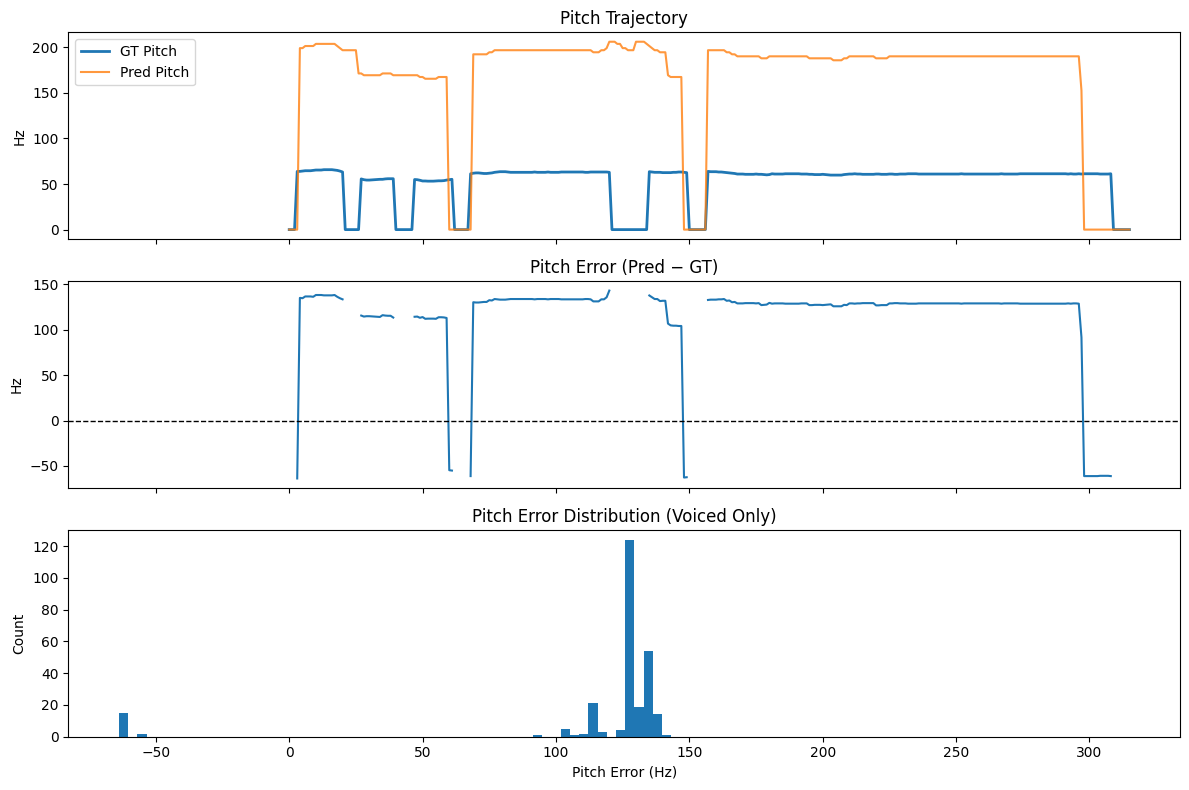

{'VRR': tensor(0.9361), 'RPA': 0.9060150384902954, 'OA': tensor(0.7057), 'mean_err': 123.95293913403216, 'std_err': 46.76880786044995}


In [111]:
stats = error_analysis_single_file(
    model,
    rrcgd_path="/home/batch_2024/ee24s004/KT/RMVPE-RRCGD-spot-computation/dataset/test/rrcgd/Ani_2_04_rrcgd.npy",
    label_path="/home/batch_2024/ee24s004/KT/RMVPE-RRCGD-spot-computation/dataset/test/labels/Ani_2_04.npy",
    device=device,
    smooth_k=5
)

print(stats)


In [118]:
def bin_to_hz_torch(bin_idx):
    """
    bin_idx: torch.Tensor (any shape)
    returns: torch.Tensor (Hz)
    """
    bin_idx = bin_idx.float()
    hz = 10.0 * (2.0 ** ((bin_idx * 20.0 + (1997.37 - 20.0)) / 1200.0))
    hz = torch.where(bin_idx > 0, hz, torch.zeros_like(hz))
    return hz


In [119]:
def cent_error(pred_bins, gt_bins):
    pred_bins = torch.as_tensor(pred_bins)
    gt_bins   = torch.as_tensor(gt_bins)

    mask = (gt_bins > 0) & (pred_bins > 0)

    pred_hz = bin_to_hz_torch(pred_bins[mask])
    gt_hz   = bin_to_hz_torch(gt_bins[mask])

    cents = 1200.0 * torch.log2(pred_hz / gt_hz)
    return cents



In [120]:
cents = cent_error(preds, Y)
print("Mean |cent error|:", cents.abs().mean().item())
print("Median |cent error|:", cents.abs().median().item())

Mean |cent error|: 16.556697845458984
Median |cent error|: 0.0


In [114]:
def octave_error_rate(pred_bins, gt_bins, threshold_cents=600):
    cents = cent_error(pred_bins, gt_bins)
    octave_err = torch.abs(cents) >= threshold_cents
    return octave_err.float().mean().item()


In [121]:
oer = octave_error_rate(preds, Y)
print("Octave Error Rate:", oer)


Octave Error Rate: 0.00026712968247011304


In [122]:
def cent_error_stats(pred_bins, gt_bins):
    cents = cent_error(pred_bins, gt_bins)
    return {
        "mean_abs": cents.abs().mean().item(),
        "median_abs": cents.abs().median().item(),
        "p90_abs": cents.abs().quantile(0.9).item(),
        "octave_rate": (torch.abs(cents) >= 600).float().mean().item()
    }



In [123]:
stats = cent_error_stats(preds, Y)
for k,v in stats.items():
    print(f"{k}: {v:.3f}")


mean_abs: 16.557
median_abs: 0.000
p90_abs: 40.000
octave_rate: 0.000


# Dataset split and doing the experiment

In [124]:
import os
from collections import defaultdict

BASE = "/home/batch_2024/ee24s004/KT/RMVPE-RRCGD-spot-computation/dataset/whole_data"
RRCGD_DIR = os.path.join(BASE, "rrcgd")
LABEL_DIR = os.path.join(BASE, "labels")

files = sorted(f for f in os.listdir(RRCGD_DIR) if f.endswith("_rrcgd.npy"))

singer_to_files = defaultdict(list)
for f in files:
    singer = f.split("_")[0]
    singer_to_files[singer].append(f)

print("Total singers:", len(singer_to_files))
for s in sorted(singer_to_files):
    print(s, len(singer_to_files[s]))


Total singers: 19
Ani 38
Kenshin 52
abjones 43
amy 132
annar 42
ariel 40
bobon 50
bug 38
davidson 52
fdps 48
geniusturtle 69
heycat 40
jmzen 52
khair 44
leon 97
stool 45
tammy 8
titon 45
yifen 65


In [125]:
singers = sorted(singer_to_files.keys())

train_singers = singers[:int(0.7 * len(singers))]
val_singers   = singers[int(0.7 * len(singers)):int(0.85 * len(singers))]
test_singers  = singers[int(0.85 * len(singers)):]

print("Train singers:", train_singers)
print("Val singers  :", val_singers)
print("Test singers :", test_singers)

Train singers: ['Ani', 'Kenshin', 'abjones', 'amy', 'annar', 'ariel', 'bobon', 'bug', 'davidson', 'fdps', 'geniusturtle', 'heycat', 'jmzen']
Val singers  : ['khair', 'leon', 'stool']
Test singers : ['tammy', 'titon', 'yifen']


In [126]:
BASE_OUT = "/home/batch_2024/ee24s004/KT/RMVPE-RRCGD-spot-computation/dataset/whole_data"

for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(BASE_OUT, split, "rrcgd"), exist_ok=True)
    os.makedirs(os.path.join(BASE_OUT, split, "labels"), exist_ok=True)


In [127]:
import shutil

def copy_split(singer_list, split):
    for singer in singer_list:
        for f in singer_to_files[singer]:
            shutil.copy(
                os.path.join(RRCGD_DIR, f),
                os.path.join(BASE_OUT, split, "rrcgd", f)
            )
            lbl = f.replace("_rrcgd.npy", ".npy")
            shutil.copy(
                os.path.join(LABEL_DIR, lbl),
                os.path.join(BASE_OUT, split, "labels", lbl)
            )

copy_split(train_singers, "train")
copy_split(val_singers, "val")
copy_split(test_singers, "test")


In [128]:
def count(split):
    r = len(os.listdir(os.path.join(BASE_OUT, split, "rrcgd")))
    l = len(os.listdir(os.path.join(BASE_OUT, split, "labels")))
    print(split, "RRCGD:", r, "Labels:", l)

count("train")
count("val")
count("test")


train RRCGD: 696 Labels: 696
val RRCGD: 186 Labels: 186
test RRCGD: 118 Labels: 118


In [129]:
def get_singers(split):
    return set(f.split("_")[0] for f in os.listdir(os.path.join(BASE_OUT, split, "rrcgd")))

assert get_singers("train").isdisjoint(get_singers("test"))
assert get_singers("train").isdisjoint(get_singers("val"))
assert get_singers("val").isdisjoint(get_singers("test"))
print("Singer-disjoint split verified.")


Singer-disjoint split verified.


## training for singer split dataset

In [3]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import torch.nn as nn 
import torch.nn.functional as F

class RRCGDDataset(Dataset):
    def __init__(self, rrcgd_dir, label_dir):
        self.files = sorted([
            f for f in os.listdir(rrcgd_dir)
            if f.endswith("_rrcgd.npy")
        ])
        self.rrcgd_dir = rrcgd_dir
        self.label_dir = label_dir

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        rrcgd_path = os.path.join(self.rrcgd_dir, self.files[idx])
        label_path = os.path.join(
            self.label_dir,
            self.files[idx].replace("_rrcgd.npy", ".npy")
        )

        X = np.load(rrcgd_path)              # (T, 256)
        y_hz = np.load(label_path)        # (T,)

        y = hz_to_bin(y_hz)                  # (T,)
        return torch.from_numpy(X), torch.from_numpy(y)

In [ ]:
import numpy as np

F_REF = 10.0        # Hz
CENTS_PER_BIN = 20
N_BINS = 300        # bins 0..299 (0 = unvoiced)

def hz_to_bin(f0_hz: np.ndarray):
    """
    f0_hz: (T,) float array, Hz, unvoiced = 0
    returns: (T,) int array, bins
    """
    bins = np.zeros_like(f0_hz, dtype=np.int64)
    voiced = f0_hz > 0

    cents = 1200 * np.log2(f0_hz[voiced] / F_REF)
    bins_voiced = np.floor(cents / CENTS_PER_BIN).astype(np.int64)

    bins_voiced = np.clip(bins_voiced, 1, N_BINS - 1)
    bins[voiced] = bins_voiced
    return bins

In [4]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    Xs, Ys = zip(*batch)

    lengths = torch.tensor([x.shape[0] for x in Xs])

    Xs = pad_sequence(Xs, batch_first=True)  # (B, T, 256)
    Ys = pad_sequence(Ys, batch_first=True)  # (B, T)

    mask = (Ys != 0).float()                 # voiced mask

    return Xs, Ys, mask, lengths

In [5]:
import torch

def compute_metrics(logits, targets, mask, tol=1):
    """
    tol: pitch tolerance in bins (±tol for RPA)
    """
    with torch.no_grad():
        preds = torch.argmax(logits, dim=-1)  # (B,T)

        voiced_gt = targets > 0
        voiced_pred = preds > 0

        # VRR: voiced recall
        vrr = (voiced_pred & voiced_gt).sum() / (voiced_gt.sum() + 1e-8)

        # RPA: correct pitch within tolerance, only on voiced frames
        pitch_diff = torch.abs(preds - targets)
        rpa = ((pitch_diff <= tol) & voiced_gt).sum() / (voiced_gt.sum() + 1e-8)

        # OA: overall accuracy (voiced + unvoiced)
        oa = (preds == targets).sum() / targets.numel()

    return {
        "VRR": vrr.item(),
        "RPA": rpa.item(),
        "OA": oa.item()
    }

In [10]:
import torch.nn.functional as F

def masked_ce_loss(logits, targets, mask, uv_weight=0.3):
    B, T, C = logits.shape
    logits = logits.view(-1, C)
    targets = targets.view(-1)
    mask = mask.view(-1)

    ce = nn.CrossEntropyLoss(reduction="none")(logits, targets)

    w = torch.ones_like(ce)
    w[mask == 0] = uv_weight   # unvoiced downweight
    return (ce * w).mean()

In [356]:
import torch
import torch.nn as nn

def rmvpe_like_loss(logits, targets, mask, voiced_weight=5.0):
    B, T, C = logits.shape
    logits = logits.reshape(-1, C)
    targets = targets.reshape(-1)
    mask = mask.reshape(-1)

    ce = nn.CrossEntropyLoss(reduction="none")(logits, targets)

    w = torch.ones_like(ce)
    w[mask == 1] = voiced_weight   # voiced upweight

    return (ce * w).mean()

In [432]:
import torch
import torch.nn.functional as F

def rmvpe_bce_loss(pred, target, pos_weight=5.0):
    """
    pred   : (B, T, 360) sigmoid output
    target : (B, T, 360) one-hot
    """

    pred = pred.clamp(1e-7, 1 - 1e-7)

    weight = torch.ones_like(target)
    weight[target == 1] = pos_weight

    loss = F.binary_cross_entropy(
        pred,
        target,
        weight=weight,
        reduction="mean"
    )
    return loss


In [433]:
def decode_cent(y_hat):
    """
    y_hat: (360,) sigmoid output
    """
    m = y_hat.argmax()
    idx = torch.arange(max(0, m-4), min(360, m+5), device=y_hat.device)
    c_hat = (y_hat[idx] * idx).sum() / y_hat[idx].sum()
    return c_hat

In [357]:
# # Normal CE weighted loss

# def train_one_epoch(model, loader, optimizer, device,uv_weight):
#     model.train()
#     total_loss = 0
#     # uv_weight=0.3
#     for X, Y, mask, _ in loader:
#         X, Y, mask = X.to(device), Y.to(device), mask.to(device)

#         optimizer.zero_grad()
#         logits = model(X)
#         loss = masked_ce_loss(logits, Y, mask,uv_weight)
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()

#     return total_loss / len(loader)

In [358]:
# RMVPE like weight cross entropy loss
def train_one_epoch(
    model,
    loader,
    optimizer,
    device,
    voiced_weight=5.0
):
    model.train()
    total_loss = 0.0

    for batch in loader:
        feats   = batch[0].to(device)   # (B,T,256)
        targets = batch[1].to(device)   # (B,T)
        mask    = batch[2].to(device)   # (B,T)

        optimizer.zero_grad()

        logits = model(feats)

        loss = rmvpe_like_loss(
            logits=logits,
            targets=targets,
            mask=mask,
            voiced_weight=voiced_weight
        )

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

In [359]:
class BiGRU(nn.Module):
    def __init__(self, input_features, hidden_features, num_layers):
        super(BiGRU, self).__init__()
        self.gru = nn.GRU(input_features, hidden_features, num_layers=num_layers, batch_first=True, bidirectional=True)

    def forward(self, x):
        return self.gru(x)[0]


class BiLSTM(nn.Module):
    def __init__(self, input_features, hidden_features, num_layers):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_features, hidden_features, num_layers=num_layers, batch_first=True, bidirectional=True)

    def forward(self, x):
        return self.lstm(x)[0]

In [360]:
def bin_to_hz(bin_idx):
    """
    bin_idx: ndarray or tensor of shape (T,)
    """
    bin_idx = np.asarray(bin_idx)
    hz = 10 * (2 ** ((bin_idx * 20 + (1997.37 - 20)) / 1200))
    hz[bin_idx == 0] = 0.0
    return hz


In [361]:
def voiced_mask_from_target(y):
    return y > 0   # bin 0 = unvoiced


In [362]:
def compute_vrr(pred, target):
    gt_voiced = target > 0
    pred_voiced = pred > 0
    return (pred_voiced & gt_voiced).sum() / (gt_voiced.sum() + 1e-8)


In [363]:
# def compute_rpa(pred, target):
#     mask = target > 0
#     pred_hz = bin_to_hz(pred[mask])
#     tgt_hz  = bin_to_hz(target[mask])

#     cents_err = 1200 * torch.log2(pred_hz / tgt_hz)
#     correct = torch.abs(cents_err) < 50
#     return correct.float().mean()

def compute_rpa(pred_bins, target_bins):
    """
    Raw Pitch Accuracy (±50 cents), voiced only
    """
    pred_bins = torch.as_tensor(pred_bins)
    target_bins = torch.as_tensor(target_bins)

    mask = target_bins > 0
    if mask.sum() == 0:
        return torch.tensor(0.0)

    pred_hz = torch.as_tensor(bin_to_hz(pred_bins[mask].cpu().numpy()))
    tgt_hz  = torch.as_tensor(bin_to_hz(target_bins[mask].cpu().numpy()))

    cents_err = 1200 * torch.log2(pred_hz / tgt_hz)
    correct = torch.abs(cents_err) < 50

    return correct.float().mean().item()


In [364]:
def compute_oa(pred, target):
    correct_unvoiced = (pred == 0) & (target == 0)
    correct_voiced   = (pred > 0) & (target > 0) & (pred == target)
    return (correct_unvoiced | correct_voiced).float().mean()


In [365]:
import scipy.signal as sg

def smooth_preds(preds, k=5):
    # preds: (B,T)
    preds_s = preds.clone()
    for b in range(preds.shape[0]):
        preds_s[b] = torch.from_numpy(
            sg.medfilt(preds[b].cpu().numpy(), kernel_size=k)
        )
    return preds_s


In [366]:
def evaluate_full(model, loader, device, smooth=True):
    model.eval()
    VRR, RPA, OA, n = 0, 0, 0, 0

    with torch.no_grad():
        for X, Y, mask, _ in loader:
            X, Y, mask = X.to(device), Y.to(device), mask.to(device)

            logits = model(X)
            preds = logits.argmax(dim=-1)

            if smooth:
                preds = smooth_preds(preds, k=5)

            VRR += compute_vrr(preds.cpu(), Y.cpu())
            RPA += compute_rpa(preds.cpu(), Y.cpu())
            OA  += compute_oa(preds.cpu(), Y.cpu())
            n += 1

    return VRR/n, RPA/n, OA/n

In [367]:
# # Normal CE weighted loss

# def validate_with_loss(model, loader, device, uv_weight):
#     model.eval()
#     total_loss = 0
#     n = 0

#     with torch.no_grad():
#         for X, Y, mask, _ in loader:
#             X, Y, mask = X.to(device), Y.to(device), mask.to(device)
#             logits = model(X)
#             loss = masked_ce_loss(logits, Y, mask, uv_weight)
#             total_loss += loss.item()
#             n += 1

#     return total_loss / n

In [368]:
@torch.no_grad()
def validate_with_loss(
    model,
    loader,
    device,
    voiced_weight=5.0
):
    model.eval()
    total_loss = 0.0

    for batch in loader:
        feats   = batch[0].to(device)
        targets = batch[1].to(device)
        mask    = batch[2].to(device)

        logits = model(feats)

        loss = rmvpe_like_loss(
            logits=logits,
            targets=targets,
            mask=mask,
            voiced_weight=voiced_weight
        )

        total_loss += loss.item()

    return total_loss / len(loader)


### Run from here for experiment

In [331]:
print ("a")

a


In [370]:
del model
del optimizer
del train_loader
del val_loader

In [372]:
torch.cuda.empty_cache()
import gc
gc.collect()

0

In [373]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [374]:
import torch
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.get_device_name(1))

2
NVIDIA GeForce RTX 4090
NVIDIA GeForce RTX 4090


In [375]:
from torch.utils.data import DataLoader, random_split

rrcgd_dir = "dataset/whole_data/train/rrcgd"
label_dir = "dataset/whole_data/train/labels"

dataset = RRCGDDataset(rrcgd_dir, label_dir)

train_ds = RRCGDDataset(
    "dataset/whole_data/train/rrcgd",
    "dataset/whole_data/train/labels"
)
val_ds = RRCGDDataset(
    "dataset/whole_data/val/rrcgd",
    "dataset/whole_data/val/labels"
)
test_ds = RRCGDDataset(
    "dataset/whole_data/test/rrcgd",
    "dataset/whole_data/test/labels"
)
batch_size=16
train_loader = DataLoader(train_ds, batch_size, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size, shuffle=False, collate_fn=collate_fn)


In [376]:
# class TemporalResBlock(nn.Module):
#     def __init__(self, ch, dilation):
#         super().__init__()
#         self.block = nn.Sequential(
#             nn.Conv1d(ch, ch, 3, padding=dilation, dilation=dilation),
#             nn.BatchNorm1d(ch),
#             nn.ReLU(),
#             nn.Conv1d(ch, ch, 3, padding=dilation, dilation=dilation),
#             nn.BatchNorm1d(ch),
#         )

#     def forward(self, x):
#         return torch.relu(x + self.block(x))


# class RRCGDNet(nn.Module):
#     def __init__(self, n_bins=360):
#         super().__init__()

#         self.frontend = nn.Sequential(
#             nn.Conv1d(256, 128, 3, padding=1),
#             nn.BatchNorm1d(128),
#             nn.ReLU(),
#             TemporalResBlock(128, dilation=2),
#             TemporalResBlock(128, dilation=4),
#         )

#         self.gru = nn.GRU(
#             input_size=128,
#             hidden_size=192,
#             num_layers=2,
#             batch_first=True,
#             bidirectional=True,
#             dropout=0.2
#         )

#         self.fc = nn.Sequential(
#             nn.Linear(384, 256),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(256, n_bins)
#         )

#     def forward(self, x):
#         # x: (B,T,256)
#         x = x.transpose(1, 2)      # (B,256,T)
#         x = self.frontend(x)
#         x = x.transpose(1, 2)      # (B,T,128)
#         x, _ = self.gru(x)         # (B,T,384)
#         return self.fc(x)

In [377]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

In [378]:
# class ConvBlock(nn.Module):
#     def __init__(self, in_ch, out_ch):
#         super().__init__()
#         self.block = nn.Sequential(
#             nn.Conv2d(in_ch, out_ch, 3, padding=1),
#             nn.BatchNorm2d(out_ch),
#             nn.ReLU(),
#             nn.Conv2d(out_ch, out_ch, 3, padding=1),
#             nn.BatchNorm2d(out_ch),
#             nn.ReLU(),
#         )

#     def forward(self, x):
#         return self.block(x)

In [379]:
# class EncoderBlock(nn.Module):
#     def __init__(self, in_ch, out_ch):
#         super().__init__()
#         self.conv = ConvBlock(in_ch, out_ch)
#         self.pool = nn.MaxPool2d(kernel_size=(2,1))  # ↓ time only

#     def forward(self, x):
#         x = self.conv(x)
#         return x, self.pool(x)

In [380]:
# class DecoderBlock(nn.Module):
#     def __init__(self, in_ch, out_ch):
#         super().__init__()
#         self.up = nn.ConvTranspose2d(
#             in_ch, out_ch, kernel_size=(2,1), stride=(2,1)
#         )
#         self.conv = ConvBlock(in_ch, out_ch)

#     def forward(self, x, skip):
#         x = self.up(x)
#         x = torch.cat([x, skip], dim=1)
#         return self.conv(x)

In [381]:
# class SimpleUNet(nn.Module):
#     def __init__(self, n_bins=360):
#         super().__init__()

#         # Encoder
#         self.enc1 = nn.Sequential(
#             nn.Conv2d(1, 64, 3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU()
#         )
#         self.enc2 = nn.Sequential(
#             nn.Conv2d(64, 128, 3, stride=(2,1), padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU()
#         )

#         # Bottleneck
#         self.mid = nn.Sequential(
#             nn.Conv2d(128, 256, 3, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU()
#         )

#         # Decoder (NOTE channel fix)
#         self.dec1 = nn.Sequential(
#             nn.ConvTranspose2d(256, 128, kernel_size=(2,1), stride=(2,1)),
#             nn.BatchNorm2d(128),
#             nn.ReLU()
#         )

#         self.out = nn.Conv2d(128, 1, 1)

#         # Temporal modeling
#         self.gru = nn.GRU(
#             input_size=256,
#             hidden_size=192,
#             num_layers=2,
#             batch_first=True,
#             bidirectional=True
#         )

#         self.fc = nn.Linear(384, n_bins)

#     def forward(self, x):
#         # x: (B,T,256)
#         x = x.unsqueeze(1).transpose(2,3)   # (B,1,256,T)

#         e1 = self.enc1(x)                    # (B,64,256,T)
#         e2 = self.enc2(e1)                   # (B,128,128,T)
#         m  = self.mid(e2)                    # (B,256,128,T)

#         d1 = self.dec1(m)                    # (B,128,256,T)
#         o  = self.out(d1).squeeze(1)         # (B,256,T)

#         o = o.transpose(1,2)                 # (B,T,256)
#         o,_ = self.gru(o)
#         return self.fc(o)


In [382]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class ConvBlock(nn.Module):
    def __init__(self, cin, cout):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(cin, cout, 3, padding=1),
            nn.BatchNorm2d(cout),
            nn.ReLU(),
            nn.Conv2d(cout, cout, 3, padding=1),
            nn.BatchNorm2d(cout),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.block(x)

In [383]:
class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = ConvBlock(in_ch, out_ch)
        self.pool = nn.AvgPool2d((2,1))

    def forward(self, x):
        s = self.conv(x)
        return s, self.pool(s)


class Up(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=(2,1), stride=(2,1))
        self.conv = ConvBlock(out_ch + skip_ch, out_ch)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

In [431]:
#Model 1 

class RRCGDNet_UNet(nn.Module):
    def __init__(self, n_bins=360):
        super().__init__()

        # Encoder (shallower)
        self.down1 = Down(1, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)

        # Bottleneck (256 → 256)
        self.mid = ConvBlock(256, 256)

        # Decoder
        self.up3 = Up(256, 256, 128)
        self.up2 = Up(128, 128, 64)
        self.up1 = Up(64, 64, 64)

        self.out_conv = nn.Conv2d(64, 1, 1)

        # Channel expansion
        self.expand = nn.Conv1d(256, 512, 1)

        # Temporal frontend
        self.temporal = nn.Sequential(
            nn.Conv1d(512, 512, 3, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Conv1d(512, 512, 3, padding=2, dilation=2),
            nn.BatchNorm1d(512),
            nn.ReLU(),
        )

        # BiGRU
        self.gru = nn.GRU(
            input_size=512,
            hidden_size=192,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=0.2
        )

        self.fc = nn.Linear(384, 360)
        self.act = nn.Sigmoid()

    def forward(self, x):
        # x: (B, T, 256)
        x = x.unsqueeze(1).transpose(2, 3)  # (B,1,256,T)

        s1, x = self.down1(x)
        s2, x = self.down2(x)
        s3, x = self.down3(x)

        x = self.mid(x)

        x = self.up3(x, s3)
        x = self.up2(x, s2)
        x = self.up1(x, s1)

        x = self.out_conv(x).squeeze(1)   # (B,256,T)

        x = self.expand(x)                # (B,512,T)
        x = self.temporal(x)              # (B,512,T)

        x = x.transpose(1, 2)             # (B,T,512)

        x, _ = self.gru(x)
        x = self.fc(x)
        return self.act(x)   # (B, T, 360)

In [409]:
# #model 2
# class RRCGDNet_UNet(nn.Module):
#     def __init__(self, n_bins=360):
#         super().__init__()

#         # Encoder
#         self.down1 = Down(1, 64)
#         self.down2 = Down(64, 128)
#         self.down3 = Down(128, 256)
#         self.down4 = Down(256,512)

#         # Bottleneck
#         self.mid = ConvBlock(512, 512)

#         # Decoder
#         self.up4 = Up(512,512,256)
#         self.up3 = Up(256, 256, 128)
#         self.up2 = Up(128, 128, 64)
#         self.up1 = Up(64, 64, 64)

#         self.out_conv = nn.Conv2d(64, 1, 1)

#         self.expand = nn.Conv1d(256,512,1)

#         # Temporal frontend
#         self.temporal = nn.Sequential(
#             nn.Conv1d(512, 512, 3, padding=1),
#             nn.BatchNorm1d(512),
#             nn.ReLU(),
#             nn.Conv1d(512, 512, 3, padding=2, dilation=2),
#             nn.BatchNorm1d(512),
#             nn.ReLU(),
#         )

#         # BiGRU
#         self.gru = nn.GRU(
#             input_size=512,
#             hidden_size=192,
#             num_layers=2,
#             batch_first=True,
#             bidirectional=True,
#             dropout=0.2
#         )

#         self.fc = nn.Linear(384, n_bins)

#     def forward(self, x):
#         # x: (B, T, 256)
#         x = x.unsqueeze(1).transpose(2, 3)  # (B,1,256,T)

#         s1, x = self.down1(x)
#         s2, x = self.down2(x)
#         s3, x = self.down3(x)
#         s4, x = self.down4(x)

#         x = self.mid(x)

#         x = self.up4(x, s4)
#         x = self.up3(x, s3)
#         x = self.up2(x, s2)
#         x = self.up1(x, s1)

#         x = self.out_conv(x).squeeze(1)   # (B,256,T)
        
#         # DO NOT transpose here
#         x = self.expand(x)                # (B,512,T)
#         x = self.temporal(x)              # (B,512,T)
        
#         # Only now convert to (B,T,C) for GRU
#         x = x.transpose(1, 2)             # (B,T,512)
        
#         x, _ = self.gru(x)
#         return self.fc(x)


In [410]:
# #model3 

# class RRCGDNet_UNet(nn.Module):
#     def __init__(self, n_bins=360):
#         super().__init__()

#         # Encoder
#         self.down1 = Down(1, 64)
#         self.down2 = Down(64, 128)
#         self.down3 = Down(128, 256)
#         self.down4 = Down(256,512)

#         # Bottleneck
#         self.mid = ConvBlock(512, 512)

#         # Decoder
#         self.up4 = Up(512,512,256)
#         self.up3 = Up(256, 256, 128)
#         self.up2 = Up(128, 128, 64)
#         self.up1 = Up(64, 64, 64)

#         self.out_conv = nn.Conv2d(64, 1, 1)

#         self.expand = nn.Conv1d(256,512,1)

#         # Temporal frontend
#         # ---- Channel expansion ----
#         self.expand1 = nn.Conv1d(256, 512, kernel_size=1)
#         self.expand2 = nn.Conv1d(512, 1024, kernel_size=1)
        
#         # ---- Temporal blocks ----
#         self.temporal1 = nn.Sequential(
#             nn.Conv1d(512, 512, 3, padding=1),
#             nn.BatchNorm1d(512),
#             nn.ReLU(),
#             nn.Conv1d(512, 512, 3, padding=2, dilation=2),
#             nn.BatchNorm1d(512),
#             nn.ReLU(),
#         )
        
#         self.temporal2 = nn.Sequential(
#             nn.Conv1d(1024, 1024, 3, padding=1),
#             nn.BatchNorm1d(1024),
#             nn.ReLU(),
#             nn.Conv1d(1024, 1024, 3, padding=2, dilation=2),
#             nn.BatchNorm1d(1024),
#             nn.ReLU(),
#         )


#         self.gru = nn.GRU(
#             input_size=1024,
#             hidden_size=256,
#             num_layers=2,
#             batch_first=True,
#             bidirectional=True,
#             dropout=0.2
#         )
        
#         self.fc = nn.Linear(512, n_bins)
        

#     def forward(self, x):
#         # x: (B, T, 256)
#         x = x.unsqueeze(1).transpose(2, 3)  # (B,1,256,T)

#         s1, x = self.down1(x)
#         s2, x = self.down2(x)
#         s3, x = self.down3(x)
#         s4, x = self.down4(x)

#         x = self.mid(x)

#         x = self.up4(x, s4)
#         x = self.up3(x, s3)
#         x = self.up2(x, s2)
#         x = self.up1(x, s1)

#         x = self.out_conv(x).squeeze(1)   # (B,256,T)
        
#         x = self.expand1(x)               # (B,512,T)
#         x = self.temporal1(x)             # (B,512,T)
        
#         x = self.expand2(x)               # (B,1024,T)
#         x = self.temporal2(x)             # (B,1024,T)
        
#         x = x.transpose(1, 2)             # (B,T,1024)
        
#         x, _ = self.gru(x)
#         return self.fc(x)
        


In [411]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# x = torch.randn(2, 100, 256).to(device)
# model = SimpleUNet().to(device)
# y = model(x)
# print(y.shape)  # must be (2, 100, n_bins)

In [412]:
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [413]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RRCGDNet_UNet().to(device)

if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

optimizer = torch.optim.AdamW(model.parameters(),lr=2e-4,weight_decay=1e-4)

In [414]:
device

device(type='cuda')

In [415]:
class EarlyStopping:
    def __init__(self, patience=8, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = -1e9
        self.count = 0
        self.stop = False

    def step(self, value):
        if value > self.best + self.min_delta:
            self.best = value
            self.count = 0
            return True   # improvement
        else:
            self.count += 1
            if self.count >= self.patience:
                self.stop = True
            return False


In [416]:
import os
import torch

def save_checkpoint(epoch, model, optimizer, best_val_oa, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)

    model_state = (
        model.module.state_dict()
        if isinstance(model, torch.nn.DataParallel)
        else model.state_dict()
    )

    torch.save(
        {
            "epoch": epoch,
            "model_state": model_state,
            "optimizer_state": optimizer.state_dict(),
            "best_val_oa": best_val_oa,
        },
        path,
    )


def load_checkpoint(path, model, optimizer, device):
    ckpt = torch.load(path, map_location=device)

    if isinstance(model, torch.nn.DataParallel):
        model.module.load_state_dict(ckpt["model_state"])
    else:
        model.load_state_dict(ckpt["model_state"])

    optimizer.load_state_dict(ckpt["optimizer_state"])

    start_epoch = ckpt["epoch"] + 1
    best_val_oa = ckpt["best_val_oa"]

    return start_epoch, best_val_oa


In [417]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=5)

In [418]:
# num_epochs = 100

# train_losses = []
# val_losses = []
# val_vrrs, val_rpas, val_oas = [], [], []

# uv_weight = 0.3
# best_val_oa = 0.0
# best_val_rpa = 0.0
# start_epoch = 1

# early_stopper = EarlyStopping(patience=10, min_delta=1e-4)

# # ---- Resume if exists ----
# if os.path.exists(LAST_PATH):
#     start_epoch, best_val_oa = load_checkpoint(
#         LAST_PATH, model, optimizer, device
#     )
#     print(f"Resumed from epoch {start_epoch}, best OA={best_val_oa:.4f}, best RPA={best_val_rpa:.4f}")

# # ---- Training loop ----
# for epoch in range(start_epoch, num_epochs + 1):

#     # ---- Train ----
#     train_loss = train_one_epoch(
#         model, train_loader, optimizer, device, uv_weight
#     )


#     train_losses.append(train_loss)

#     # ---- Validate (loss) ----
#     val_loss = validate_with_loss(
#         model, val_loader, device, uv_weight
#     )
#     val_losses.append(val_loss)

#     # ---- Validate (metrics) ----
#     vrr, rpa, oa = evaluate_full(
#         model, val_loader, device
#     )
#     val_vrrs.append(vrr)
#     val_rpas.append(rpa)
#     val_oas.append(oa)

#     # ---- Scheduler ----
#     scheduler.step(oa)

#     # ---- Save last checkpoint ----
#     save_checkpoint(
#         epoch, model, optimizer, best_val_oa,
#         "checkpoints/model_RRCGDNet_UNet3/uv_weight_0.3/last.pt"
#     )

#     # ---- Save best model (by OA) ----
#     if oa > best_val_oa:
#         best_val_oa = oa
#         save_checkpoint(
#             epoch, model, optimizer, best_val_oa,
#             "checkpoints/model_RRCGDNet_UNet2/uv_weight_0.3/best_oa.pt"
#         )
#     if rpa > best_val_rpa:
#         best_val_rpa = rpa
#         save_checkpoint(epoch, model, optimizer, best_val_rpa,"checkpoints/model_RRCGDNet_UNet2/uv_weight_0.3/best_rpa.pt")

#     # ---- Logging (single print) ----
#     print(
#         f"Epoch {epoch:03d} | "
#         f"Train {train_loss:.6f} | "
#         f"Val {val_loss:.6f} | "
#         f"VRR {vrr:.3f} | RPA {rpa:.3f} | OA {oa:.3f}"
#     )

#     # ---- Early stopping (RPA-focused) ----
#     early_stopper.step(rpa)
#     if early_stopper.stop:
#         print("Early stopping triggered")
#         break

In [419]:
num_epochs = 100
voiced_weight = 5.0

train_losses = []
val_losses = []
val_vrrs, val_rpas, val_oas = [], [], []

best_val_oa = 0.0
best_val_rpa = 0.0
start_epoch = 1

early_stopper = EarlyStopping(patience=10, min_delta=1e-4)

# ---- Resume if exists ----
if os.path.exists(LAST_PATH):
    start_epoch, best_val_oa = load_checkpoint(
        LAST_PATH, model, optimizer, device
    )

# ---- Training loop ----
for epoch in range(start_epoch, num_epochs + 1):

    # ---- Train ----
    train_loss = train_one_epoch(
        model,
        train_loader,
        optimizer,
        device,
        voiced_weight=voiced_weight
    )
    train_losses.append(train_loss)

    # ---- Validate (loss) ----
    val_loss = validate_with_loss(
        model,
        val_loader,
        device,
        voiced_weight=voiced_weight
    )
    val_losses.append(val_loss)

    # ---- Validate (metrics) ----
    vrr, rpa, oa = evaluate_full(
        model,
        val_loader,
        device
    )
    val_vrrs.append(vrr)
    val_rpas.append(rpa)
    val_oas.append(oa)

    # ---- Scheduler ----
    scheduler.step(oa)

    # ---- Save last ----
    save_checkpoint(
        epoch,
        model,
        optimizer,
        best_val_oa,
        "checkpoints/model_RRCGDNet_UNet/RMVPE_Loss_5/last.pt"
    )

    # ---- Save best OA ----
    if oa > best_val_oa:
        best_val_oa = oa
        save_checkpoint(
            epoch,
            model,
            optimizer,
            best_val_oa,
            "checkpoints/model_RRCGDNet_UNet1/RMVPE_Loss_5/best_oa.pt"
        )

    # ---- Save best RPA ----
    if rpa > best_val_rpa:
        best_val_rpa = rpa
        save_checkpoint(
            epoch,
            model,
            optimizer,
            best_val_rpa,
            "checkpoints/model_RRCGDNet_UNet1/RMVPE_Loss_5/best_rpa.pt"
        )

    # ---- Log ----
    print(
        f"Epoch {epoch:03d} | "
        f"Train {train_loss:.6f} | "
        f"Val {val_loss:.6f} | "
        f"VRR {vrr:.3f} | RPA {rpa:.3f} | OA {oa:.3f}"
    )

    # ---- Early stopping (RPA) ----
    early_stopper.step(rpa)
    if early_stopper.stop:
        print("Early stopping triggered")
        break


Epoch 001 | Train 10.515288 | Val 7.673713 | VRR 0.520 | RPA 0.482 | OA 0.594
Epoch 002 | Train 5.495678 | Val 5.397411 | VRR 0.849 | RPA 0.739 | OA 0.629
Epoch 003 | Train 4.013802 | Val 4.766089 | VRR 0.940 | RPA 0.802 | OA 0.623
Epoch 004 | Train 3.305553 | Val 4.418868 | VRR 0.952 | RPA 0.807 | OA 0.649
Epoch 005 | Train 2.859899 | Val 4.299159 | VRR 0.903 | RPA 0.789 | OA 0.687
Epoch 006 | Train 2.501862 | Val 4.058426 | VRR 0.867 | RPA 0.782 | OA 0.716
Epoch 007 | Train 2.201115 | Val 4.219477 | VRR 0.776 | RPA 0.726 | OA 0.731
Epoch 008 | Train 2.031670 | Val 3.727496 | VRR 0.950 | RPA 0.850 | OA 0.694
Epoch 009 | Train 1.842579 | Val 3.741516 | VRR 0.933 | RPA 0.834 | OA 0.709
Epoch 010 | Train 1.684736 | Val 4.199344 | VRR 0.792 | RPA 0.743 | OA 0.739
Epoch 011 | Train 1.544851 | Val 3.867340 | VRR 0.970 | RPA 0.854 | OA 0.678
Epoch 012 | Train 1.390704 | Val 3.764363 | VRR 0.919 | RPA 0.834 | OA 0.724
Epoch 013 | Train 1.249467 | Val 4.105938 | VRR 0.843 | RPA 0.780 | OA 0.74

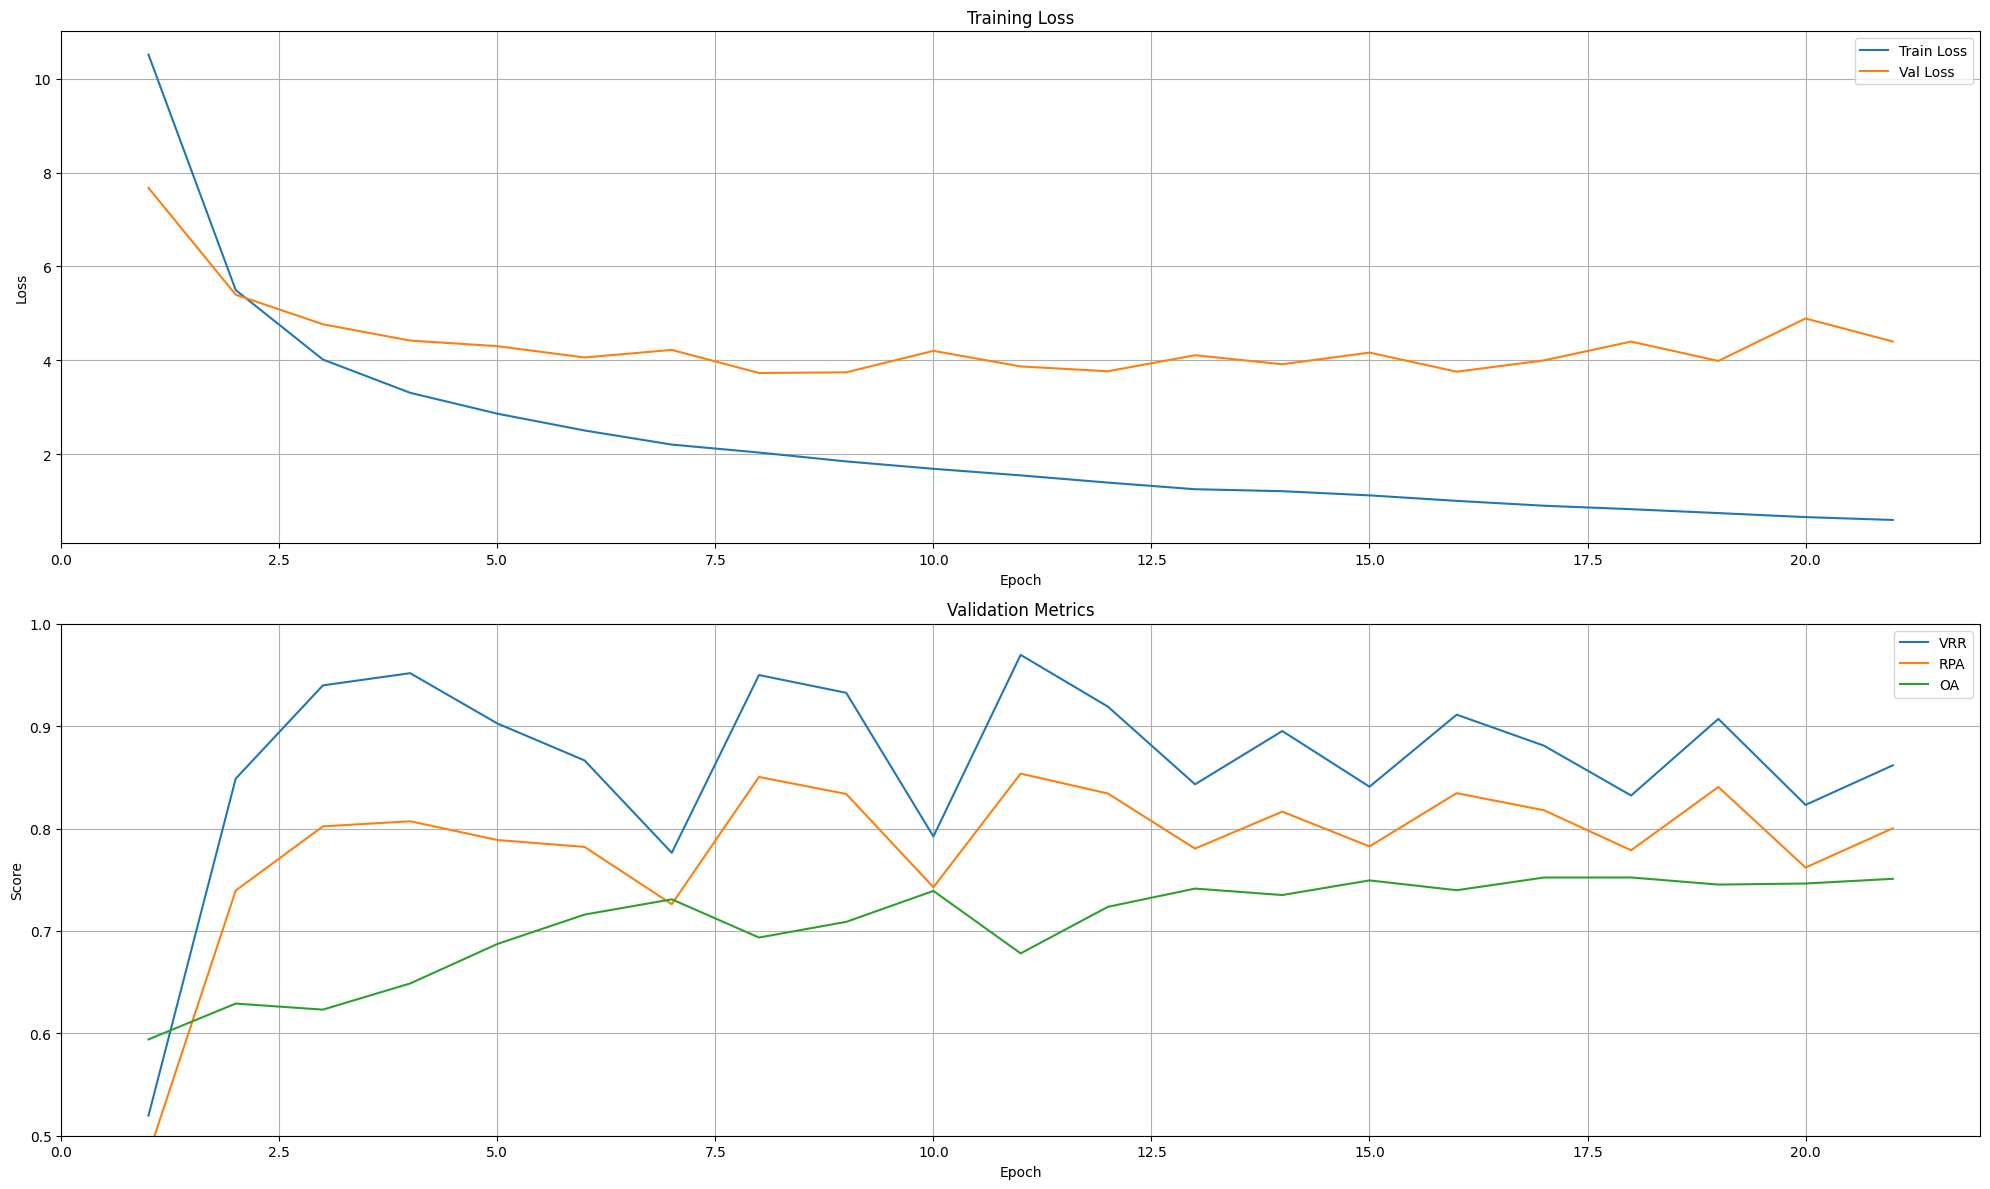

In [420]:
import matplotlib.pyplot as plt
%matplotlib inline

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(20, 12))

# ---- Loss ----
plt.subplot(2, 1, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.legend()

# ---- Metrics ----
plt.subplot(2, 1, 2)
plt.plot(epochs, val_vrrs, label="VRR")
plt.plot(epochs, val_rpas, label="RPA")
plt.plot(epochs, val_oas, label="OA")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation Metrics")
plt.ylim(0.5,1)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig("checkpoints/model_RRCGDNet_UNet1/RMVPE_Loss_5/training_curves.png", dpi=200)  # SAVE FIRST
plt.show()
plt.close()


In [421]:
import numpy as np

def ema(x, alpha=0.3):
    y = np.zeros_like(x, dtype=float)
    y[0] = x[0]
    for i in range(1, len(x)):
        y[i] = alpha * x[i] + (1 - alpha) * y[i-1]
    return y


In [397]:
train_losses_s = ema(train_losses, alpha=0.3)
val_losses_s   = ema(val_losses, alpha=0.3)

val_vrrs_s = ema(val_vrrs, alpha=0.3)
val_rpas_s = ema(val_rpas, alpha=0.3)
val_oas_s  = ema(val_oas,  alpha=0.3)

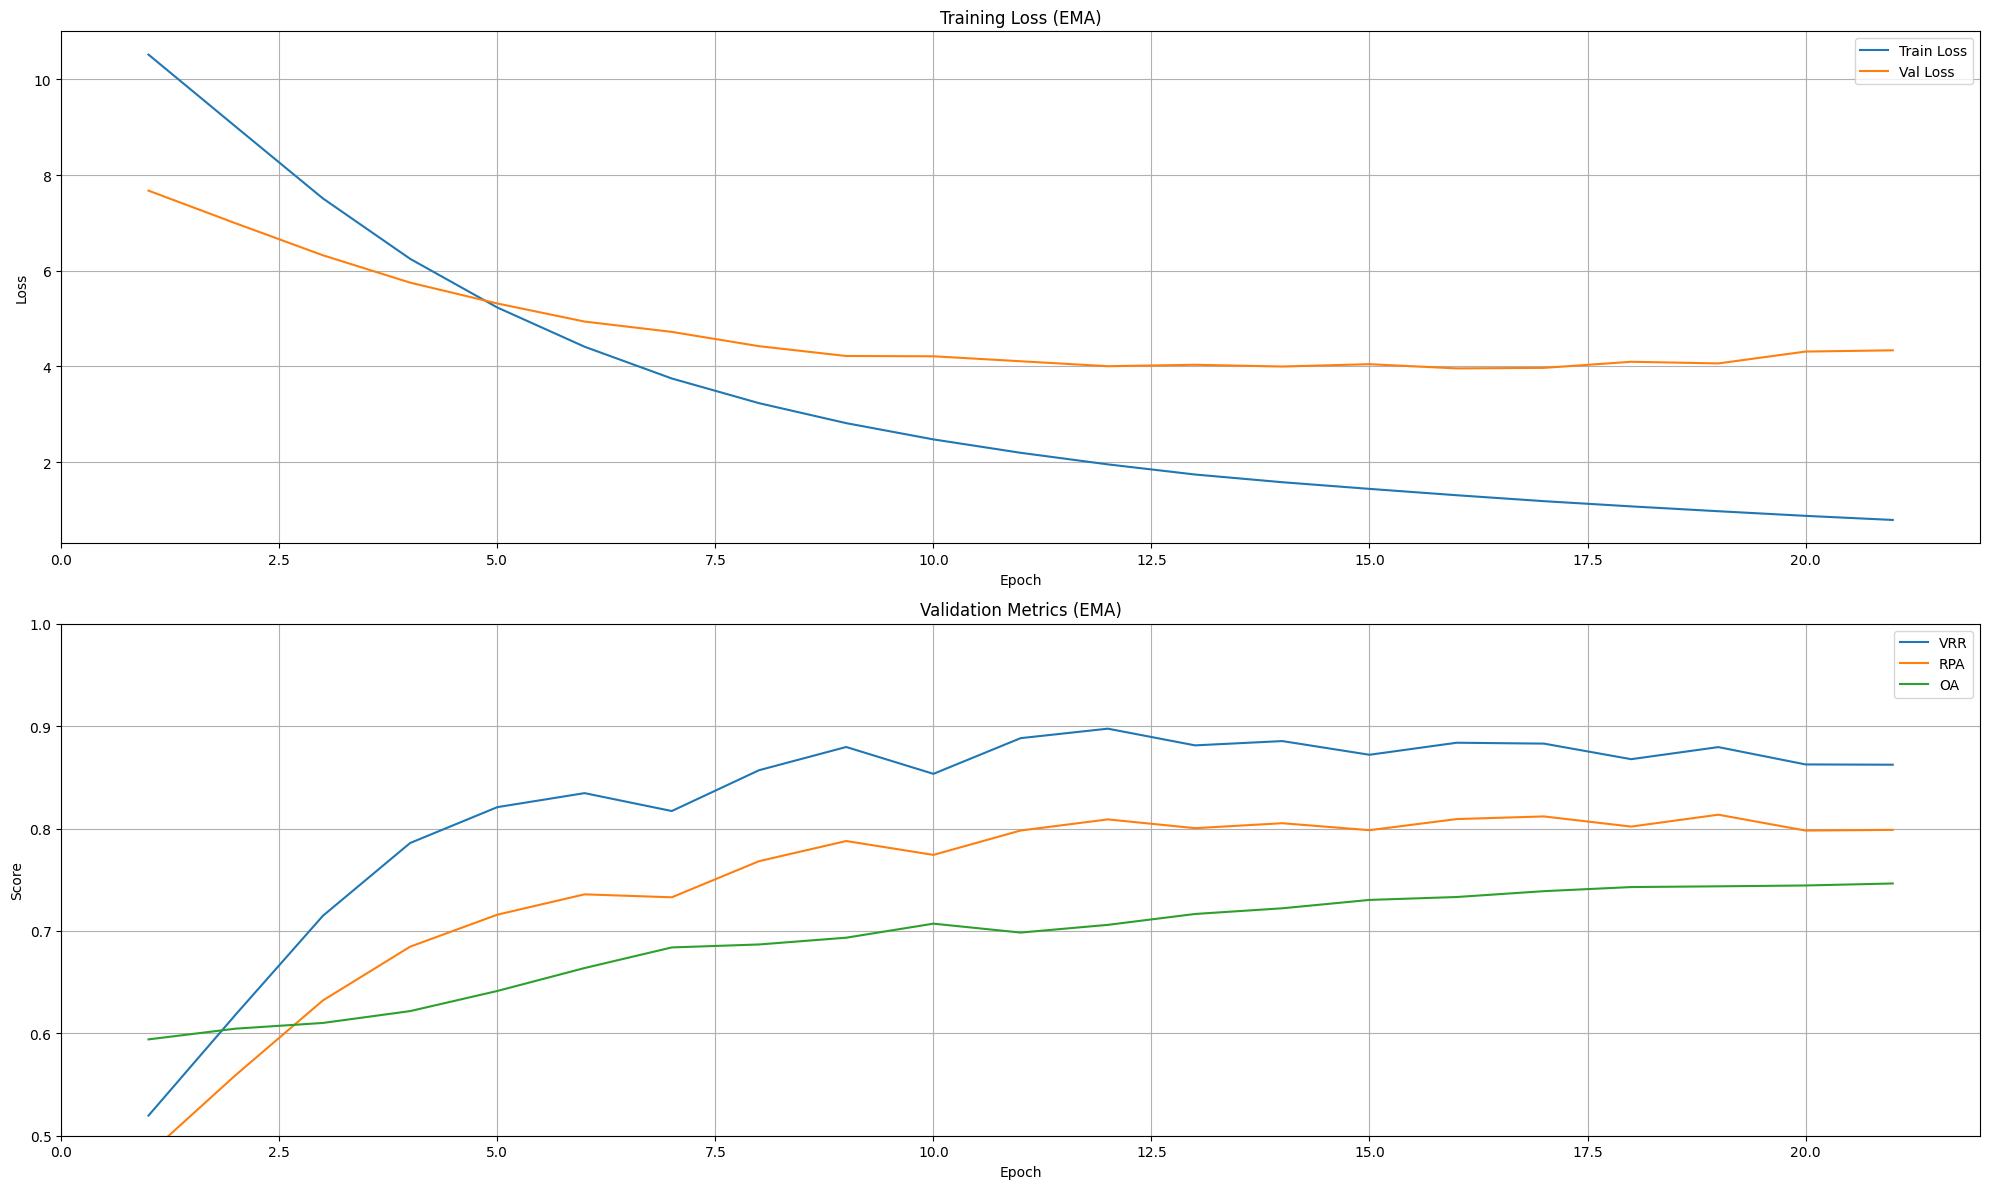

In [422]:
epochs = np.arange(1, len(train_losses) + 1)

plt.figure(figsize=(20,12))

# ---- Loss ----
plt.subplot(2,1,1)
plt.plot(epochs, ema(train_losses, 0.3), label="Train Loss")
plt.plot(epochs, ema(val_losses, 0.3), label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss (EMA)")
plt.grid(True)
plt.legend()

# ---- Metrics ----
plt.subplot(2,1,2)
plt.plot(epochs, ema(val_vrrs, 0.3), label="VRR")
plt.plot(epochs, ema(val_rpas, 0.3), label="RPA")
plt.plot(epochs, ema(val_oas,  0.3), label="OA")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.ylim(0.5, 1.0)
plt.title("Validation Metrics (EMA)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig("checkpoints/model_RRCGDNet_UNet1/RMVPE_Loss_5/smooth_training_curves.png", dpi=200)
plt.show()
plt.close()


In [423]:

# test_vrr, test_rpa, test_oa = evaluate_full(model, test_loader, device)

# print(
#     f"[TEST] VRR={test_vrr:.3f} | "
#     f"RPA={test_rpa:.3f} | OA={test_oa:.3f}"
# )


In [424]:
def model_summary(model):
    total = 0
    for name, p in model.named_parameters():
        if p.requires_grad:
            total += p.numel()
    return total

n_params = model_summary(model)
print(f"Total trainable parameters: {n_params:,}")

with open("checkpoints/model_RRCGDNet_UNet1/RMVPE_Loss_5/model_stats.txt", "w") as f:
    f.write(f"Total trainable parameters: {n_params}\n")


Total trainable parameters: 6,592,361


In [425]:
import json
import os
from datetime import datetime

def save_test_results(
    test_vrr, test_rpa, test_oa,
    ckpt_dir="checkpoints/model_RRCGDNet_UNet1/RMVPE_Loss_5/"
):
    os.makedirs(ckpt_dir, exist_ok=True)

    results = {
        "timestamp": datetime.now().isoformat(),
        "VRR": test_vrr,
        "RPA": test_rpa,
        "OA": test_oa,
    }

    out_path = os.path.join(ckpt_dir, "test_results.json")
    with open(out_path, "w") as f:
        json.dump(results, f, indent=2)

    print(f"[LOGGED] Test results → {out_path}")


In [426]:
save_test_results(test_vrr, test_rpa, test_oa)

[LOGGED] Test results → checkpoints/model_RRCGDNet_UNet1/RMVPE_Loss_5/test_results.json


In [427]:
import torch

model.eval()

# unwrap DataParallel
export_model = model.module if isinstance(model, torch.nn.DataParallel) else model

dummy_input = torch.randn(1, 200, 256).to(device)  # (B,T,F) adjust T if needed

torch.onnx.export(
    export_model,
    dummy_input,
    "checkpoints/model_RRCGDNet_UNet1/RMVPE_Loss_5/model.onnx",
    input_names=["rrcgd"],
    output_names=["logits"],
    dynamic_axes={
        "rrcgd": {1: "time"},
        "logits": {1: "time"}
    },
    opset_version=14
)


In [428]:
!pip install torchinfo

In [429]:
from torchinfo import summary

summary(
    export_model,
    input_size=(1, 200, 256),  # (B,T,F)
    col_names=["input_size", "output_size", "num_params"],
    depth=4
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
RRCGDNet_UNet                            [1, 200, 256]             [1, 200, 360]             --
├─Down: 1-1                              [1, 1, 256, 200]          [1, 64, 256, 200]         --
│    └─ConvBlock: 2-1                    [1, 1, 256, 200]          [1, 64, 256, 200]         --
│    │    └─Sequential: 3-1              [1, 1, 256, 200]          [1, 64, 256, 200]         --
│    │    │    └─Conv2d: 4-1             [1, 1, 256, 200]          [1, 64, 256, 200]         640
│    │    │    └─BatchNorm2d: 4-2        [1, 64, 256, 200]         [1, 64, 256, 200]         128
│    │    │    └─ReLU: 4-3               [1, 64, 256, 200]         [1, 64, 256, 200]         --
│    │    │    └─Conv2d: 4-4             [1, 64, 256, 200]         [1, 64, 256, 200]         36,928
│    │    │    └─BatchNorm2d: 4-5        [1, 64, 256, 200]         [1, 64, 256, 200]         128
│    │    │    └─ReLU: 4-6  

In [430]:
with open("checkpoints/model_RRCGDNet_UNet1/RMVPE_Loss_5/summary.txt", "w") as f:
    f.write(str(summary(export_model, input_size=(1,200,256))))


### The problem was with test data having 50 extra files which are also there in train. Should remove them now

In [72]:
# import os

# BASE = "/home/batch_2024/ee24s004/KT/RMVPE-RRCGD-spot-computation/dataset"

# train_lbl = os.path.join(BASE, "train/labels")
# test_lbl  = os.path.join(BASE, "test/labels")

# train_files = set(f for f in os.listdir(train_lbl) if f.endswith(".npy"))
# test_files  = set(f for f in os.listdir(test_lbl) if f.endswith(".npy"))

# overlap = sorted(train_files & test_files)

# print("Train labels:", len(train_files))
# print("Test labels :", len(test_files))
# print("Overlapping :", len(overlap))
# print("First 10 overlaps:", overlap[:10])


Train labels: 800
Test labels : 250
Overlapping : 50
First 10 overlaps: ['Ani_1_03.npy', 'Ani_1_04.npy', 'Ani_4_10.npy', 'Ani_5_02.npy', 'Ani_5_04.npy', 'Kenshin_2_01.npy', 'Kenshin_3_08.npy', 'Kenshin_5_01.npy', 'Kenshin_5_08.npy', 'abjones_3_04.npy']


In [73]:
# deleted = []

# for f in overlap:
#     path = os.path.join(test_lbl, f)
#     os.remove(path)
#     deleted.append(f)

# print("Deleted from test:", len(deleted))


Deleted from test: 50


In [74]:
# test_files_after = set(f for f in os.listdir(test_lbl) if f.endswith(".npy"))
# assert len(train_files & test_files_after) == 0

# print("✔ No overlap between train and test labels")
# print("Final test label count:", len(test_files_after))

✔ No overlap between train and test labels
Final test label count: 200


In [75]:
# import os

# BASE = "/home/batch_2024/ee24s004/KT/RMVPE-RRCGD-spot-computation/dataset"

# train_rrcgd = os.path.join(BASE, "train/rrcgd")
# test_rrcgd  = os.path.join(BASE, "test/rrcgd")

# train_files = set(f for f in os.listdir(train_rrcgd) if f.endswith("_rrcgd.npy"))
# test_files  = set(f for f in os.listdir(test_rrcgd) if f.endswith("_rrcgd.npy"))

# overlap = sorted(train_files & test_files)

# print("Train RRCGD:", len(train_files))
# print("Test RRCGD :", len(test_files))
# print("Overlapping:", len(overlap))
# print("First 10 overlaps:", overlap[:10])

Train RRCGD: 800
Test RRCGD : 250
Overlapping: 50
First 10 overlaps: ['Ani_1_03_rrcgd.npy', 'Ani_1_04_rrcgd.npy', 'Ani_4_10_rrcgd.npy', 'Ani_5_02_rrcgd.npy', 'Ani_5_04_rrcgd.npy', 'Kenshin_2_01_rrcgd.npy', 'Kenshin_3_08_rrcgd.npy', 'Kenshin_5_01_rrcgd.npy', 'Kenshin_5_08_rrcgd.npy', 'abjones_3_04_rrcgd.npy']


In [76]:
# deleted = []
# for f in overlap:
#     os.remove(os.path.join(test_rrcgd, f))
#     deleted.append(f)

# print("Deleted from test RRCGD:", len(deleted))

Deleted from test RRCGD: 50


In [77]:
# test_after = set(f for f in os.listdir(test_rrcgd) if f.endswith("_rrcgd.npy"))
# assert len(train_files & test_after) == 0

# print("✔ No overlap between train and test RRCGD")
# print("Final test RRCGD count:", len(test_after))

✔ No overlap between train and test RRCGD
Final test RRCGD count: 200
